# Predicting Player Win Rates

In this notebook, we'll explore the potential of predicting each player's win rate and identifying the key statistics that significantly influence their success in matches. By analyzing and understanding these factors, we can gain valuable insights into the game and player dynamics, which will impact how we assess each player's skill level. For these experiments, we will focus solely on exploring baseline models for proof of concept.

---

## Initial Setup

In [1]:
# ---------------- Basic Data Science Libraries ---------------- #
import numpy as np # Linear algebra
import pandas as pd # Data processing

# ---------------- System Libraries ---------------- #
import os # Miscellaneous operating system interfaces
import gc # Garbage collector interface
from tempfile import mkdtemp # Creates a temporary directory
import nbimporter # Use functions from other Jupyter Notebooks'
from Data_Cleaning_and_Exploration import is_integer_series
from Data_Cleaning_and_Exploration import read_file
from subprocess import check_output # Saves results written to the current directory as output
import random

# ---------------- Plotting Libraries ---------------- #
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()

# ---------------- SKlearn Library ---------------- #
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import probplot

# ---------------- Define Clean and Raw Directories ---------------- #
clean_folder = '../Data/Clean'
raw_folder = '../Data/Raw'
merged_folder = '../Data/Merged'

# ---------------- Set new DataFrame limiters ---------------- #
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# ---------------- Print files in my clean data folder ---------------- #
print(check_output(['ls', merged_folder]).decode('utf8'))

final_df.csv
matches.csv
matches_simple.csv
players.csv
timeseries.csv
timeseries.csv.zip



---

## Data Preparation

In [2]:
# Load the data
df = read_file('players.csv', merged_folder)
print('--------------------------------------------------------------')
df.head(10)

../Data/Merged/players.csv: 498,980 observations, 71 features
--------------------------------------------------------------


match_id  match_outcome                        account account_id  hero_id  \
0         0              1                       Double T   Double T       86   
1         0              1                         Monkey          1       51   
2         0              1                       Trash!!!   Trash!!!       83   
3         0              1                              2          2       11   
4         0              1                           Kira          3       67   
5         0              0                              4          4      106   
6         0              0                      6k Slayer  6k Slayer      102   
7         0              0                        ｔｏｍｉａ～♥          5       46   
8         0              0                              -    0_0_131        7   
9         0              0  u didnt see who highest here?          6       73   

   player_slot  gold  gold_spent  gold_per_min  xp_per_min  denies  last_hits  \
0            0  3261       10960           347         362       1         30   
1            1  2954       17760           494         659       9        109   
2            2   110       12195           350         385       1         58   
3            3  1179       22505           599         605       6        271   
4            4  3307       23825           613         762      13        245   
5          128   476       12285           397         524       5        162   
6          129   317       10355           303         369       2        107   
7          130  2390       13395           452         517      31        208   
8          131   475        5035           189         223       0         27   
9          132    60       17550           496         456       0        147   

     stuns  hero_damage  hero_healing  tower_damage  item_0  item_1  item_2  \
0  76.7356         8690           218           143     180      37      73   
1  87.4164        23747             0           423      46      63     119   
2   0.0000         4217          1595           399      48      60      59   
3   0.0000        14832          2714          6055      63     147     154   
4   0.0000        33740           243          1833     114      92     147   
5   0.0000        10725             0           112     145      73     149   
6   0.0000        15028           764             0      50      11     102   
7   0.0000        10230             0          2438      41      63      36   
8  67.0277         4774             0             0      36       0       0   
9  60.9748         6398           292             0      63       9     116   

   item_3  item_4  item_5  level  leaver_status  xp_hero  xp_creep  xp_roshan  \
0      56     108       0     16              0     8840      5440          0   
1     102      24     108     22              0    14331      8440       2683   
2     108      65       0     17              0     6692      8112          0   
3     164      79     160     21              0     8583     14230        894   
4       0     137      63     24              0    15814     14325          0   
5      48     212       0     19              0     8502     12259          0   
6      36     185      81     16              0     5201      9417          0   
7     147     168      21     19              0     6853     13396          0   
8      46       0     180     12              0     4798      4038          0   
9      65     229      79     18              0     6659     10471          0   

   xp_other  gold_other  gold_death  gold_buyback  gold_killing_heros  \
0        83          50        -957             0                5145   
1       671         395       -1137             0                6676   
2       453         259       -1436         -1015                2418   
3       293         100       -2156             0                4104   
4        62           0       -1437         -1056                7467   
5         1        

### Feature Selection

We should choose the characteristics that provide a comprehensive view of each player's overall performance across all matches. It's essential to consider each player's preferred position to identify which particular metrics have a greater impact on winning, depending on the player's position.

In [3]:
# Look at the DataFrame column names for referrence
df.columns

Index(['match_id', 'match_outcome', 'account', 'account_id', 'hero_id',
       'player_slot', 'gold', 'gold_spent', 'gold_per_min', 'xp_per_min',
       'denies', 'last_hits', 'stuns', 'hero_damage', 'hero_healing',
       'tower_damage', 'item_0', 'item_1', 'item_2', 'item_3', 'item_4',
       'item_5', 'level', 'leaver_status', 'xp_hero', 'xp_creep', 'xp_roshan',
       'xp_other', 'gold_other', 'gold_death', 'gold_buyback',
       'gold_killing_heros', 'gold_killing_creeps', 'gold_killing_roshan',
       'messages_sent', 'time_played', 'cluster', 'start_time',
       'tower_status_radiant', 'tower_status_dire', 'barracks_status_dire',
       'barracks_status_radiant', 'first_blood_time', 'hero_primary_attribute',
       'hero_role_nuker', 'hero_role_initiator', 'hero_role_durable',
       'hero_role_pusher', 'hero_role_support', 'hero_role_carry',
       'hero_role_disabler', 'hero_role_escape', 'kda', 'radiant_team',
       'team_kda', 'team_denies', 'team_gold', 'team_gold_spent',

In [4]:
def get_preferred_positions(player_slots):
    slot_positions = {
        0: 1, 1: 2, 2: 3, 3: 4, 4: 5,
        128: 1, 129: 2, 130: 3, 131: 4, 132: 5
    }
    # Map the player slots to positions
    mapped_slots = player_slots.map(slot_positions)
    # Get the counts of each position
    slot_counts = mapped_slots.value_counts()
    # Sort the positions by frequency
    return slot_counts.index.tolist()

player_pool = df.groupby('account_id').agg({
    'kda': 'mean',
    'gold_per_min': 'mean',
    'xp_per_min': 'mean',
    'last_hits': 'mean',
    'denies': 'mean',
    'hero_damage': 'mean',
    'hero_healing': 'mean',
    'tower_damage': 'mean',
    'time_played': 'mean',
    'teamfights': 'mean',
    'player_slot': lambda x: get_preferred_positions(x)[0],
    'total_matches': 'last',
    'win_rate': 'last'
}).reset_index()

player_pool = player_pool.rename(columns={'player_slot': 'preferred_position'}).set_index('account_id')

player_pool.head()

kda  gold_per_min  xp_per_min   last_hits  \
account_id                                                                      
!                              3.473016         504.0  571.166667  135.833333   
!     Ale<3                    3.025641         514.0  566.000000  199.000000   
! ! ! ! !                      3.000000         416.0  561.000000  128.000000   
! Doriverse !                  1.538462         385.0  427.000000   80.000000   
! Dota2-shop.ir [ Book Fori ]  2.636364         861.0  646.000000  377.000000   

                               denies   hero_damage  hero_healing  \
account_id                                                          
!                                 5.5  14236.666667    599.666667   
!     Ale<3                       3.5  22374.500000      0.000000   
! ! ! ! !                         3.0  24772.000000      0.000000   
! Doriverse !                     0.0  12425.000000      0.000000   
! Dota2-shop.ir [ Book Fori ]     5.0  31055.000000      0.000000   

                               tower_damage  time_played  teamfights  \
account_id                                                             
!                                    2622.5       2132.0         8.5   
!     Ale<3                          2463.5       3480.0        12.0   
! ! ! ! !                              22.0       2387.0         6.0   
! Doriverse !                           0.0       2417.0         8.0   
! Dota2-shop.ir [ Book Fori ]        7646.0       3008.0        11.0   

                               preferred_position  total_matches  win_rate  
account_id                                                                  
!                                               4              6  0.833333  
!     Ale<3                                     3              2  1.000000  
! ! ! ! !                                       5              1  0.000000  
! Doriverse !                                   4              1  0.000000  
! Dota2-shop.ir [ Book Fori ]                   5              1  1.000000

Now that we have collected all the summarized information for each player in our dataset, it's time to begin analyzing the relationship between each feature and our target variable.

### Linear Relationship

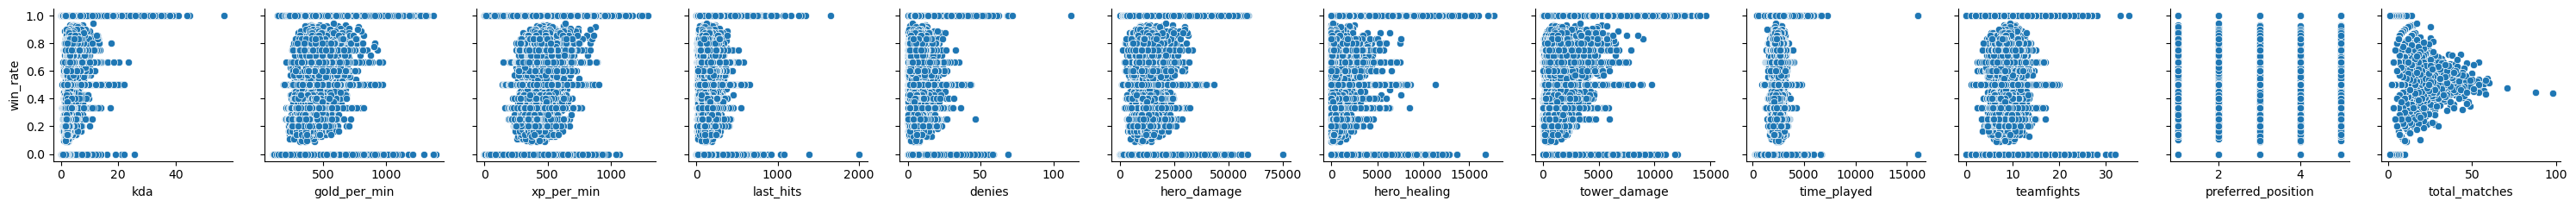

In [5]:
# List of features to check
features = ['kda', 'gold_per_min', 'xp_per_min', 'last_hits', 
            'denies', 'hero_damage', 'hero_healing', 'tower_damage', 
            'time_played', 'teamfights', 'preferred_position', 'total_matches']

# Plot scatter plots
sns.pairplot(player_pool, x_vars=features, y_vars='win_rate')
plt.tight_layout()
plt.show()

Looking at the chart above, here are some key takeaways from each metric's relationship with win rates:
- **Strong Indicators**: Higher KDAs, gold per minute, hero damage, and tower damage tend to show positive correlations with win rates.
- **Moderate Indicators**: XP per minute and last hits show moderate trends but are not strong linear indicators.
- **Weak/No Indicators**: Denies, hero healing, time played, team fights, and preferred position do not show clear correlations with win rates.
- **Experience**: As players play more matches, their win rates tend to stabilize, indicating that experienced players approach a 50% win rate.

### No Multicollinearity

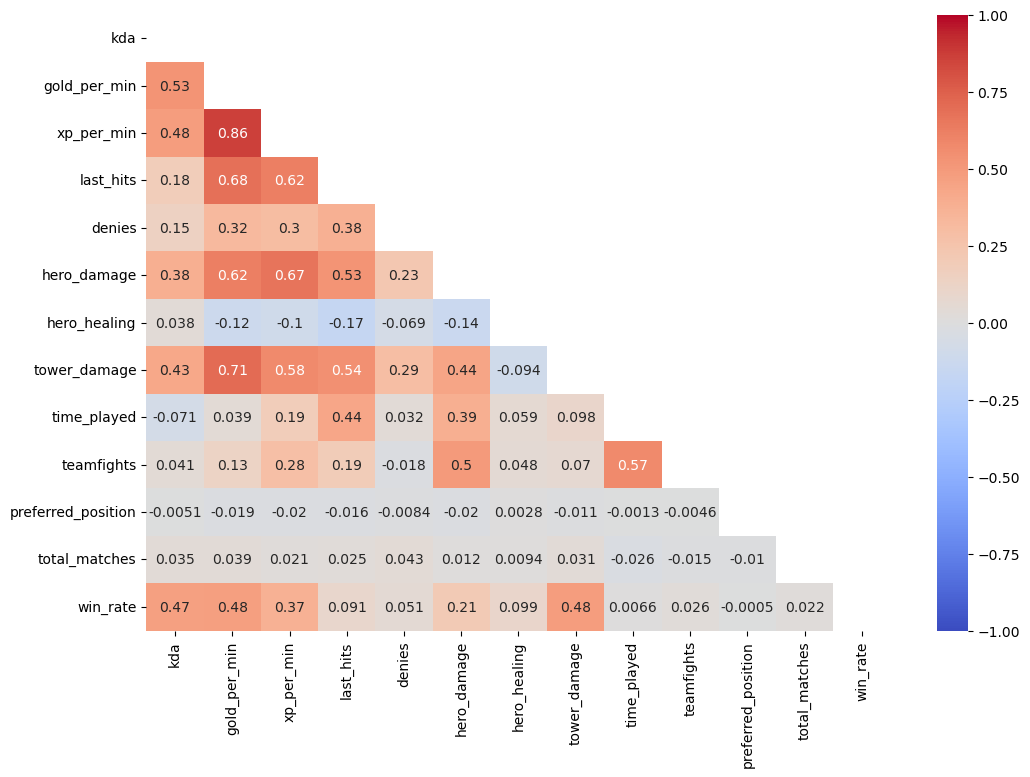

In [6]:
# Visualize a correlation matrix
corr_matrix = player_pool.corr()
mask = np.triu(corr_matrix)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

The correlation matrix above indicates that most of our features are correlated with each other. This is expected, as higher metrics may suggest better player performance. For example, higher gold and XP per minute could reflect a player's farming efficiency.

---

## Linear Regression

In [7]:
# Defining our independent features and target variable
X = player_pool[features]
y = player_pool['win_rate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the training and testing set
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Linear Regression Testing Mean Squared Error: {test_mse}")
print(f"Linear Regression Testing R-squared: {test_r2}")

Linear Regression Testing Mean Squared Error: 0.11115791265664866
Linear Regression Testing R-squared: 0.48130823965966596


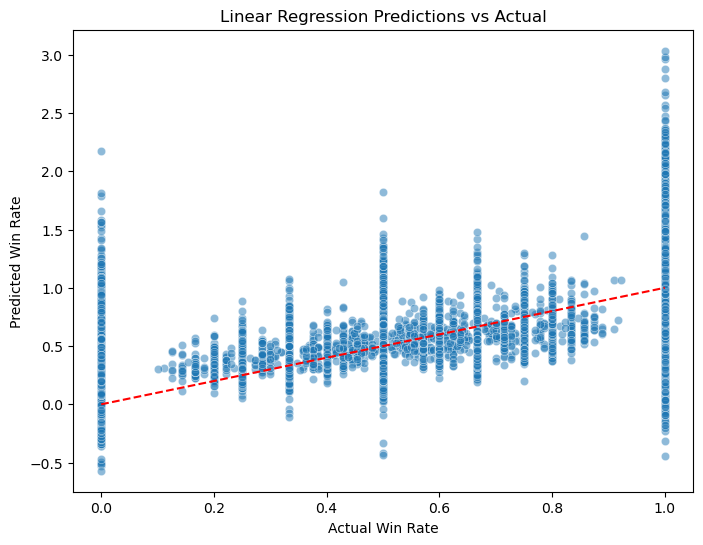

<Figure size 640x480 with 0 Axes>

In [9]:
# Plot Linear Regression Test Predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Linear Regression Predictions vs Actual')
plt.xlabel('Actual Win Rate')
plt.ylabel('Predicted Win Rate')
plt.show()

plt.tight_layout()
plt.show()

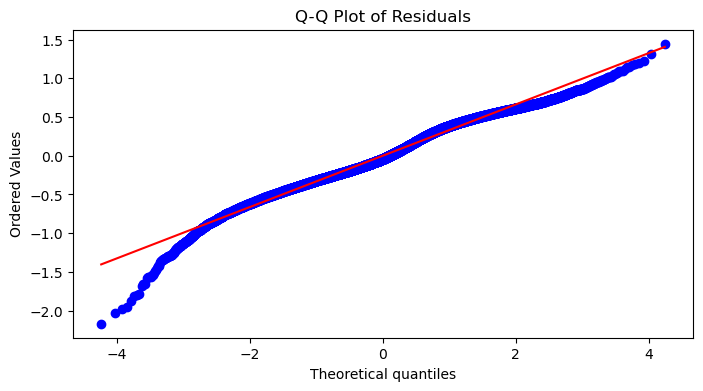

In [10]:
# Plot Q-Q Plot of residuals
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 4))
probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

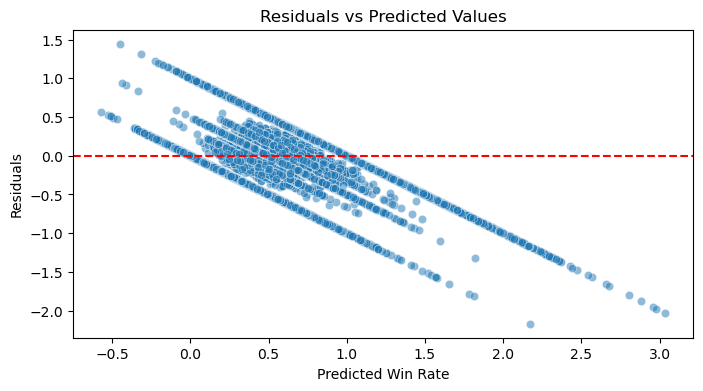

In [11]:
# Plot residuals vs predicted values
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Win Rate')
plt.ylabel('Residuals')
plt.show()

---

## Partial Least Squares (PLS)

Partial Least Squares regression is a method that can handle datasets with multicollinearity, such as this one, and is particularly useful when the predictors are highly collinear.

In [12]:
# Define the parameter grid for PLS
param_grid = {'n_components': np.arange(1, X_train_scaled.shape[1] + 1)}

# Initialize PLS regressor
pls = PLSRegression()

# Perform grid search with cross-validation for PLS
pls_cv = GridSearchCV(pls, param_grid, cv=5, scoring='r2')
pls_cv.fit(X_train_scaled, y_train)

# Get the best model
best_pls = pls_cv.best_estimator_

# Make predictions on the testing set using the best model
y_test_pred_pls = best_pls.predict(X_test_scaled)

# Evaluate the model
pls_mse = mean_squared_error(y_test, y_test_pred_pls)
pls_r2 = r2_score(y_test, y_test_pred_pls)

print(f"Best PLS n_components: {best_pls.n_components}")
print(f"PLS Testing Mean Squared Error: {pls_mse}")
print(f"PLS Testing R-squared: {pls_r2}")

Best PLS n_components: 12
PLS Testing Mean Squared Error: 0.11115791265664869
PLS Testing R-squared: 0.48130823965966574


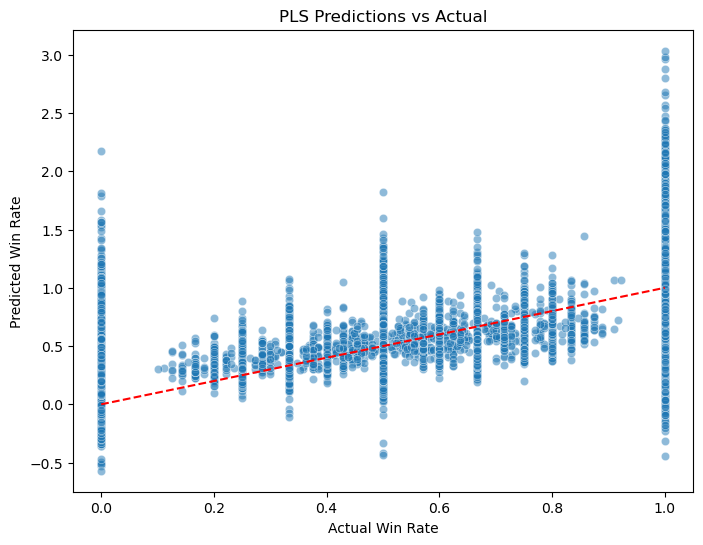

In [13]:
# Plot Test Predictions for PLS
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred_pls.flatten(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('PLS Predictions vs Actual')
plt.xlabel('Actual Win Rate')
plt.ylabel('Predicted Win Rate')
plt.show()

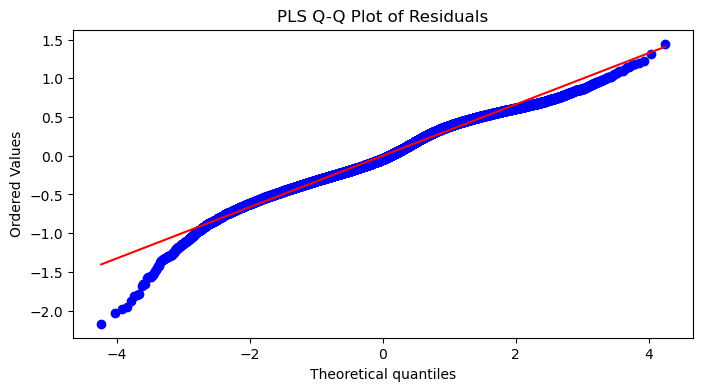

In [14]:
# Plot Q-Q Plot of residuals for PLS
residuals_pls = y_test - y_test_pred_pls.flatten()
plt.figure(figsize=(8, 4))
probplot(residuals_pls, dist="norm", plot=plt)
plt.title('PLS Q-Q Plot of Residuals')
plt.show()

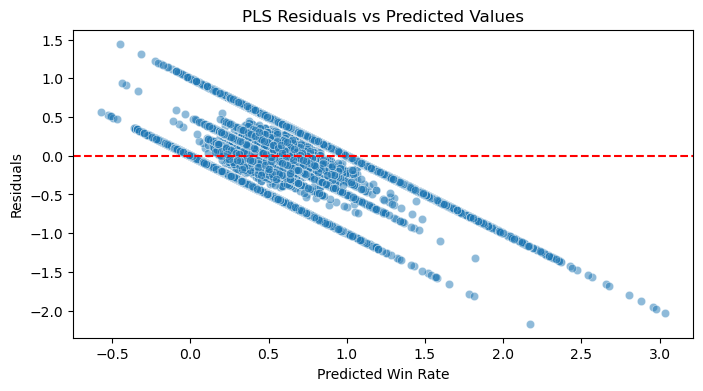

In [15]:
# Plot residuals vs predicted values for PLS
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_test_pred_pls.flatten(), y=residuals_pls, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('PLS Residuals vs Predicted Values')
plt.xlabel('Predicted Win Rate')
plt.ylabel('Residuals')
plt.show()

## Random Forest Regressor

Based on our previous attempts, we have observed that linear regression and PLS have difficulty capturing the complex, non-linear relationships between our performance metrics and win rates. On the other hand, a Random Forest could offer a strong and adaptable method for accurately predicting win rates. Here are a few reasons why this approach might be effective:

1. **Handling Non-linearity**: Random Forest Regressors can capture non-linear interactions between features, which are prevalent in scenarios where performance metrics interact in complex ways to influence win rates.

2. **Feature Importance**: This model inherently provides insights into feature importance, helping identify which performance metrics most significantly impact win rates, enabling targeted strategies for player improvement.

3. **Robustness to Overfitting**: By averaging multiple decision trees, random forests reduce the risk of overfitting, ensuring that the model generalizes well to unseen data, crucial for reliable predictions in dynamic gaming environments.

4. **Handling Multicollinearity**: Random forests are less affected by multicollinearity compared to linear models, as the decision trees within the forest can independently split on correlated features without skewing the results.

5. **Scalability**: Random Forest Regressors can efficiently handle large datasets with numerous features and instances, making them ideal for processing our dataset.

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Initialize Random Forest regressor with initial parameters
rf = RandomForestRegressor(n_estimators=100, max_features=None, max_depth=None, min_samples_split=2, min_samples_leaf=1, bootstrap=True, random_state=42)

# Fit the model
rf.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_test_pred_rf = rf.predict(X_test_scaled)

# Evaluate the model
rf_mse = mean_squared_error(y_test, y_test_pred_rf)
rf_r2 = r2_score(y_test, y_test_pred_rf)

print(f"Random Forest Testing Mean Squared Error: {rf_mse}")
print(f"Random Forest Testing R-squared: {rf_r2}")

Random Forest Testing Mean Squared Error: 0.06621016195595049
Random Forest Testing R-squared: 0.6910461465444184


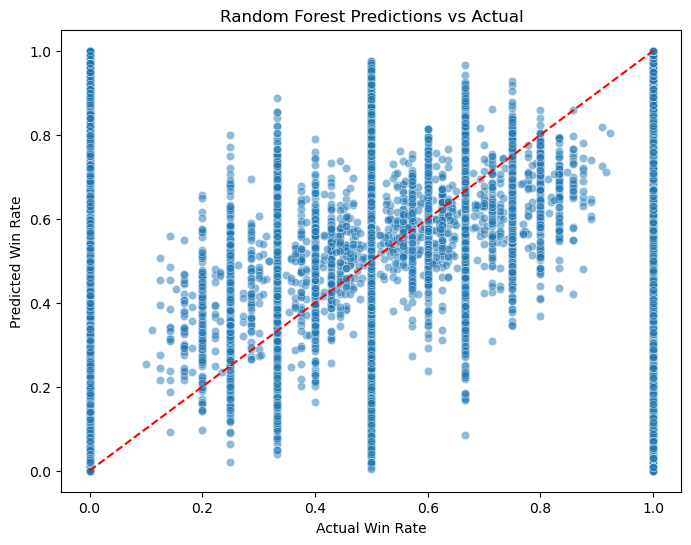

In [17]:
# Plot Test Predictions for Random Forest
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Random Forest Predictions vs Actual')
plt.xlabel('Actual Win Rate')
plt.ylabel('Predicted Win Rate')
plt.show()

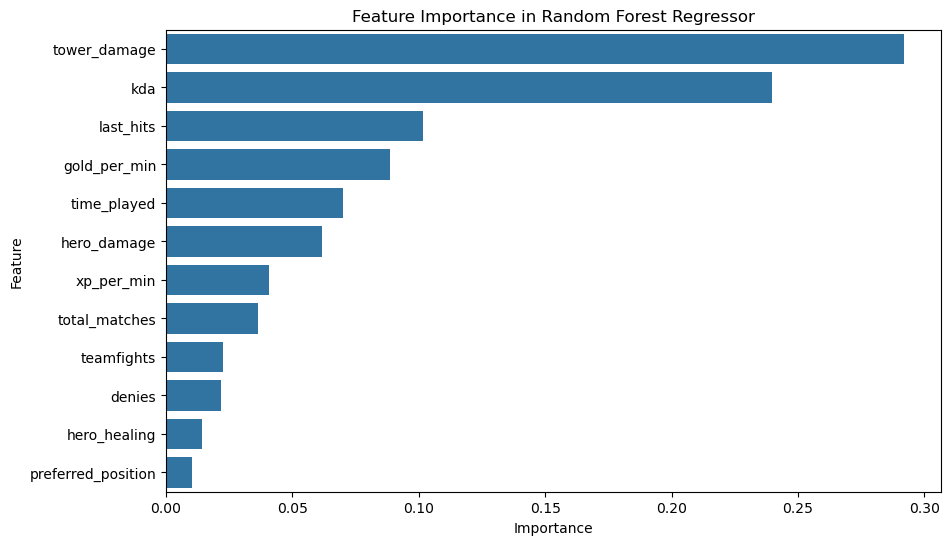

In [18]:
# Extract feature importances
importances = rf.feature_importances_
features = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

---

## Conclusions

Our analysis of model performance reveals that the Random Forest Regressor excels in predicting win rates compared to the Linear Regression and Partial Least Squares regression models. The lower mean squared error (MSE) and higher R-squared value of the Random Forest Regressor demonstrate its effectiveness in capturing non-linear interactions and complex dependencies between player performance metrics and win rates. This suggests that the Random Forest model can account for approximately 69.1% of the variability in win rates, leading to more accurate predictions.

Our investigation using the Random Forest model identified combat efficiency (measured by the KDA ratio), objective control (as indicated by the importance of tower damage), and efficient farming (reflected in last hits and gold per minute) as the most significant factors for predicting players' win rates.

Given the Random Forest Regressor's promising performance even without hyperparameter optimization, it is advisable to fine-tune the model to maximize its performance and conduct additional feature engineering to more effectively represent each player's ability to control objectives. With a refined model, there is potential to extract the most pertinent features related to player performance, enhancing the development of our predictive skill system.